### variable meaning
* pred: index of video sequence 
* time: predicted time step SA: 0-2, EA: 0-4
* K: index of K-th nearest neighbor

In [29]:
import torch
import pickle
import numpy as np
import sys
sys.path.append('../')
from utils.poincare_distance import poincare_distance
import os
import imageio
from IPython.display import display, Image
from tqdm.notebook import tqdm
import PIL.Image

In [47]:
embed_path = '/proj/vondrick/didac/code/DPC/logs/log_train_earlyaction_hyper_v1_poincare_kinetics_lr4/20201023_151021/embeds/model_best_epoch31_embeds.pkl'
f = open(embed_path,"rb")
feature_dict = pickle.load(f)

In [48]:
feature_dict['pred'].shape

torch.Size([75328, 7, 256])

In [49]:
feature_dict['feature'].shape

torch.Size([75328, 1, 256])

# sample examples to be searched

In [3]:
num_embeds = len(feature_dict['vpath'])

In [4]:
np.random.seed(2020)
pred_index = np.sort(np.random.choice(range(num_embeds), replace=False, size=200))

In [5]:
pred_feature = feature_dict['pred'][pred_index]
pred_vpath = [feature_dict['vpath'][pred_index[i]] for i in range(len(pred_index))]
pred_idx = feature_dict['idx_block'][pred_index]

# score matrix

In [6]:
sample_feature = feature_dict['feature']

In [7]:
score_list = []
for i in range(sample_feature.shape[1]):
    score_list.append(poincare_distance(pred_feature[:, i, :], sample_feature[:, i, :]))
score_list = torch.stack(score_list)

In [8]:
nn_indices = []
nn_values = []
for i in range(sample_feature.shape[1]):
    nn_indices.append(torch.topk(score_list[0], 10, dim=1, largest=False).indices)
    nn_values.append(torch.topk(score_list[0], 10, dim=1, largest=False).values)
nn_indices = torch.stack(nn_indices)
nn_values = torch.stack(nn_values)

# show nearest neighbors

In [14]:
def display_gif(gif_path):
    with open(gif_path,'rb') as f:
        display(Image(data=f.read(), format='png'))

In [9]:
def get_vpath(feature_dict, nn_indices, time_ind, pred_ind, K):
    '''
    Return vpath and list of K-th nearest neighbors
    '''
    sample_ind = nn_indices[time_ind][pred_ind][K]
    vpath = feature_dict['vpath'][sample_ind]
    idx_block = feature_dict['idx_block'][sample_ind]
    start = idx_block[25 + time_ind * 5] # TODO: generalize the index to arbitrary pred_step and num_seq
    end = start + 15
    return vpath, np.arange(start.item(), end.item()), sample_ind

In [40]:
def generate_gif(vpath, idx_block, sample_ind, save=True, time_ind=None, pred_ind=None, K=None):
    '''
    generate gif given vpath and idx_block, save with time, pred, K information
    '''
    if save:
        assert all(x is not None for x in [time_ind, pred_ind, K])
    images = []
    for idx in idx_block:
        im_path = os.path.join(vpath, 'image_%0.5d.jpg' % idx)
        if os.path.exists(im_path):
            images.append(PIL.Image.open(im_path))
    if save:
        NN_path = os.path.join('/'.join(embed_path.split('/')[:-1]), 'NN')
        if not os.path.exists(NN_path):
            os.mkdir(NN_path)
        gif_path = os.path.join(NN_path, 'time-%d_pred-%d_K-%d.gif' % (time_ind, pred_ind, K))
        images[0].save(gif_path, format='GIF', append_images=images[1:], save_all=True, loop=0)
        return images, gif_path
    return images

In [41]:
def view_gif(feature_dict, nn_indices, time_ind=0, pred_ind=10, K=5, show=False):
    vpath, idx_block, sample_ind = get_vpath(feature_dict, nn_indices, time_ind=time_ind, pred_ind=pred_ind, K=K)
    images, gif_path = generate_gif(vpath, idx_block, sample_ind=sample_ind, save=True, time_ind=time_ind, pred_ind=pred_ind, K=K)
    if show:
        display_gif(gif_path)

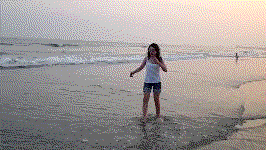

In [43]:
view_gif(feature_dict, nn_indices, time_ind=1, pred_ind=10, K=3, show=True)

# generate all pred gifs

In [44]:
for i in tqdm(range(len(pred_index))):
    pred_ind = pred_index[i]
    vpath = feature_dict['vpath'][pred_ind]
    idx_block = feature_dict['idx_block'][pred_ind]
    start = idx_block[0]
    end = start + 25 # TODO: make it general to all num_seq and pred_step
    idx_block = np.arange(start.item(), end.item())
    images = []
    for idx in idx_block:
        im_path = os.path.join(vpath, 'image_%0.5d.jpg' % idx)
        if os.path.exists(im_path):
            images.append(PIL.Image.open(im_path))
        
    NN_path = os.path.join('/'.join(embed_path.split('/')[:-1]), 'NN')
    if not os.path.exists(NN_path):
        os.mkdir(NN_path)
    gif_path = os.path.join(NN_path, 'pred-%d.gif' % i)
    images[0].save(gif_path, format='GIF', append_images=images[1:], save_all=True, loop=0)

# generate all nearest neighbor gif

In [45]:
for time_ind in range(3):
    print('time step 1')
    for pred_ind in tqdm(range(len(pred_index))):
        for K in range(3):
            view_gif(feature_dict, nn_indices, time_ind=time_ind, pred_ind=pred_ind, K=K, show=False)